* Double DQN
* prioritized ER (sampling of transitions with uniform weights)
* gradient clipping
* 3 layers, 50 hidden dim
* $\gamma = 0.98$
* activation is SELU  (useful ?)
* optimizer is Adam and learning rate is 0.0001
* there are two losses: the MSE (Bellman) and a penalty for not being in the range (-RMAX, RMAX). The total loss is the sum of these two
* maximum 10 steps of optimization for finding $argmax_{a}Q(s,a)$ with Rprop algorithm
* actions are logged. As some can be zero, we replace the zeros by the minimal action taken


In [1]:
print('ready')

ready


In [2]:
import torch as t
from torch.nn import ReLU, SELU
import numpy as np
from random import random, sample
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from IPython.display import display, clear_output
from parse_dataset import *
from rank_based import *
from icnn import ICNN, gradient_step_action, diff_params, loss_beyond_RMAX,  clip_gradients, get_q_target, update_parameters_lag
from copy import deepcopy
from utils import variable, moving_avg
import rank_based
import proportional
from time import time
import evaluation
from SepsisExperienceBuffer import  SepsisExperienceBuffer

# Load and parse dataset

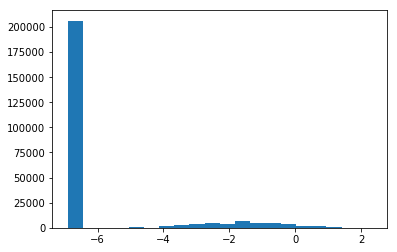

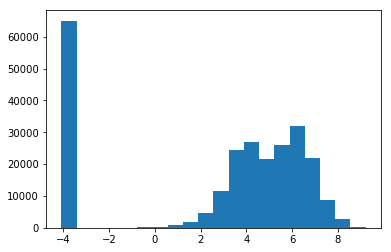

In [39]:
data = pd.read_csv('Sepsis_imp.csv')
replace_absurd_temperatures(data)
data = drop_patients_with_absurd_weights(data)
data = drop_patients_with_unrealistic_HR_or_BP(data)
data = add_relative_time_column(data)
data = drop_patient_with_negative_input(data)
add_small_quantities(data)
create_action_column(data)
add_log_actions(data)

log_scaler = StandardScaler()
scaler = StandardScaler()
action_scaler = StandardScaler()
train_idx, test_idx = split_train_test_idx(data)

# scale on train data only
scaler.fit(data.loc[data.icustayid.isin(train_idx)][numerical_columns_not_to_be_logged])
log_scaler.fit(np.log(data.loc[data.icustayid.isin(train_idx)][numerical_columns_to_be_logged]))
action_scaler.fit(data.loc[data.icustayid.isin(train_idx)][log_action_cols])

plt.hist(data.log_vaso, bins=20)
plt.show()
plt.hist(data.log_fluid, bins=20)
plt.show()

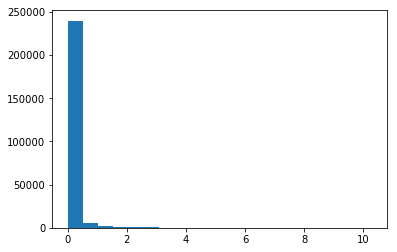

In [40]:
plt.hist(data.max_dose_vaso, bins=20)
plt.show()

Split train/test

In [41]:
test_idx, train_idx = split_train_test_idx(data)

List of transitions `(s,a,r,s')`

In [42]:
transitions_train = transition_iterator(data, idx=train_idx, scaler=scaler, log_scaler=log_scaler,  action_scaler=action_scaler, RMAX=15, log_action=True)

C:\Users\Camilo\Dropbox\Graduate Studies\Harvard\CS282r RL for Healthcare\Final Project\cs282-f17-sebastian-camilo\parse_dataset.py:264: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if idx == None:


In [43]:
transitions_dict = {k: {
    "s": values[0],
    "a": values[1],
    "r": values[2],
    "s'": values[3]   
}
 for k, values in enumerate(transitions_train)
}

print('len(transitions_dict):',len(transitions_dict))

len(transitions_dict): 12224


Compute bounds for the actions (you don't have right to prescribe less than the min or more than the max). It gives bounds to the possible actions and ensure that the max of Q can actually be found

In [44]:
# Compute extremums of action space
min0 = min([d['a'][0] for k, d in transitions_dict.items()])
max0 = max([d['a'][0] for k, d in transitions_dict.items()])
min1 = min([d['a'][1] for k, d in transitions_dict.items()])
max1 = max([d['a'][1] for k, d in transitions_dict.items()])

print('min0, max0, min1, max1:', min0, max0, min1, max1)

# Also save min and max of rewards
rmin = min([d['r'] for k, d in transitions_dict.items()])
rmax = max([d['r'] for k, d in transitions_dict.items()])
print('rmin, rmax:', rmin,rmax)

min0, max0, min1, max1: -0.440594871376 3.91733713675 -1.60180774102 1.52607942065
rmin, rmax: -15.0 15.0


In [45]:
# Compute D, which is the same as transitions_train but as a list of lists where every element is an episode

discrete_transitions = np.load('trajectories.npy')
previous_id = discrete_transitions[0,0]
D_train=[]
episode = []
for i,trans in tqdm(enumerate(discrete_transitions)):
    if trans[0] in train_idx:
        if trans[0] != previous_id:
#             print('Appending ',len(episode),'-step episode from patient',previous_id, 'to D')
            previous_id = trans[0]
            D_train.append(deepcopy(episode))
            episode = []   
        # We're using rewards -15 and 15, so we need to correct the rewards that come with the
        # file (was created with rewards -10 and 20)
        if trans[3]:
            r = trans[3]-5
        else: r = trans[3]
        episode.append((trans[1],trans[2], r, trans[4]))    

print('Final length of D_train:',len(D_train)) 
print('First few episodes of D_train:',D_train[:2])

## TODO: CHANGE TRANSITIONS SO THAT THE LAST STATE OF AN EPISODE IS STATE 751 IF ALIVE, 752 IF DEAD

252204it [00:01, 145338.90it/s]


Final length of D_train: 953
First few episodes of D_train: [[], [(1, 0, 0, 1), (1, 0, 0, 62), (62, 4, 0, 722), (722, 4, 0, 403), (403, 4, 0, 544), (544, 4, 0, 256), (256, 4, 0, 405), (405, 4, 0, 405), (405, 4, 0, 113), (113, 4, 0, 17), (17, 4, 0, 368), (368, 4, 0, 366), (366, 4, 0, 10), (10, 4, 0, 475), (475, 4, 0, 10), (10, 3, 15, 10)]]


### Build neural network
The neural network is convex in $a$

$$u_0 = x$$
$$z_0 = a$$
$$u_{i+1} = \tilde{g}_i(\tilde{W}_iu_i+b_i)$$
$$z_{i+1} = g_i\left(W_i^{(z)}(z_i \cdot (W_i^{(zu)}u_i+b_i^{(z)})_+) + W_i^{(a)}(a \cdot (W_i^{(au)}u_i+b_i^{(a)})) + W_i^{(u)}u_i+b_i\right)$$
with $$W_i^{(z)}\geq 0$$


In [46]:
Q_select = ICNN(3, 50, activation=SELU())
Q_eval = deepcopy(Q_select)

In [47]:
print('ready')

ready


### Test the Prioritized Experience Sampling

In [48]:
# # Instance a basic PER Buffer for sepsis with low batch_size for testing
# exp_buffer = SepsisExperienceBuffer(batch_size = batch_size, partition_num = batch_size, total_step = 260000)

# # Load a small subset of transitions from dataset
# c = 0
# for i in transitions_dict:
#     c = c+1
#     if c >= 50: break  
#     if transitions_dict[i]["s'"] is not None:
#         s_prime_variable = variable(transitions_dict[i]["s'"]).float().resize(1,50)
#     else:
#         s_prime_variable = variable(np.array([50*[np.nan]])).float()
        
#     exp_tuple = [variable(transitions_dict[i]['s']).float().resize(1,50), \
#         variable(transitions_dict[i]['a']).float().resize(1,2), \
#         variable(transitions_dict[i]['r']).float(), \
#         s_prime_variable]
    
#     exp_buffer.store(exp_tuple)   
    
# # Sample elements and observe priorities
    
# exp, w, rank_id = exp_buffer.sample(step)


# Get PER

In [49]:
print('ready')

ready


Create buffer with initialized priorities

Can take some time

In [50]:
# INITIALIZE SOME VARIABLES
EPOCHS = 100
batch_size = 128
gamma = .98
RMAX = 15
c = 100.  # weight of the loss "beyond RMAX"
max_steps_a = 10

# CREATE PRIORITIZED ER EXPERIENCE BUFFER
# proceed by batch
# update the priorities immediately, so that the network starts training by looking at the good things immediately
# CAN TAKE SOME TIME
exp_buffer = SepsisExperienceBuffer(batch_size = batch_size, partition_num = batch_size, total_step = 260000)
for i in range(0, len(transitions_dict), batch_size):
    s = []
    a = []
    r = []
    s_ = []
    for j in range(0, min(batch_size, len(transitions_dict) - (i+batch_size))):
        # check if state is terminal
        if transitions_dict[i+j]["s'"] is not None:
            s_.append(variable(transitions_dict[i+j]["s'"]).resize(1,50))
        else:
            s_.append(variable(np.array([50*[np.nan]])))
        s.append(variable(transitions_dict[i+j]['s']).resize(1,50))
        a.append(variable(transitions_dict[i+j]['a']).resize(1,2))
        r.append(variable(transitions_dict[i+j]['r']))
    if len(s) == 0:
        break
    s = t.cat(s)
    a = t.cat(a)
    r = t.cat(r)
    s_ = t.cat(s_)
    
    target = get_q_target(Q_select, Q_eval, s_, r, min0, max0, min1, max1, gamma=gamma, max_steps_a=max_steps_a).squeeze()
    pred = Q_select(s, a).squeeze()
    td_error = ((pred - target)**2 + c*loss_beyond_RMAX(pred, RMAX).squeeze()).data.numpy() 

    for j in range(0, min(batch_size, len(transitions_dict) - (i+batch_size))):
        exp_tuple = [s[j].resize(1, 50), a[j].resize(1,2), r[j].resize(1,1), s_[j].resize(1,50)]
        exp_buffer.store(exp_tuple, td_error[j])
        
print('Length of experience buffer:', len(exp_buffer._buffer._experience))

Length of experience buffer: 12096


# Train model

In [51]:
print('ready')

ready


In [52]:
def clip(x):
    """
    Clip values below -RMAX or above RMAX
    Might be useful when the target goes beyond
    """
    return x*((x>=-RMAX).float())*((x<=RMAX).float()) + RMAX*(x>RMAX).float() - RMAX*(x<-RMAX).float()

In [53]:
import importlib
importlib.reload(evaluation)

# OPTIMIZER PARAMETERS
learning_rate = 1e-4
optimizer = t.optim.Adam(Q_select.parameters(), lr=learning_rate)
max_steps = int(len(data) / batch_size)
max_steps_a = 10

# batch size
batch_size= 64
exp_buffer._buffer.batch_size = batch_size

# update weights target
T_UPDATE = 100  # parameter to copy the weights periodically
tau = 1e-2  # rate to update target network toward primary network

# monitoring
losses = []
average_q_pred = []
average_q_target = []
max_q_pred = []
min_q_pred = []
max_q_target = []
min_q_target = []
average_vaso = []
max_vaso = []
min_vaso = []
average_fluid = []
max_fluid = []
min_fluid = []
global_step = 0


# TRAIN
for _ in range(EPOCHS):
    t0 = time()
    for step in range(max_steps):
        global_step += 1

        # Sample batch
        t_sample = time()
        exp, w, exp_id = exp_buffer.sample(global_step)
        states = t.cat([d[0] for d in exp]).float()
        actions = t.cat([d[1] for d in exp]).float()
        rewards = t.cat([d[2] for d in exp]).float()
        next_states = t.cat([d[3] for d in exp]).float()
#         print('sample', time() - t_sample)
        
        # Init grad (set all of them to zero)
        optimizer.zero_grad()

        # Compute loss
        t_loss = time()
        pred = Q_select.forward(states, actions).squeeze()  # Q(s, a)
        target, max_actions = get_q_target(Q_select, Q_eval, next_states, rewards, min0, max0, min1, max1, gamma=gamma, max_steps_a=max_steps_a, return_max_actions=True)  # max_a' Q(s', a)
        target = clip(target.squeeze())
        loss = (pred - target)**2 + c*loss_beyond_RMAX(pred, RMAX).squeeze()  # this loss penalizes values that are not in the range [-rmax, rmax]
#         print('loss', time()-t_loss)
        
        # Update priorities
        t_update = time()
        exp_buffer.update(exp_id, loss.data.numpy().tolist())
#         print('update', time()-t_update)

        loss = loss*variable(w)
        loss = t.sum(loss)
        
        # Monitoring
        losses.append(loss.data.numpy()[0]/batch_size)
        average_q_pred.append(t.mean(pred).squeeze().data.numpy()[0])
        max_q_pred.append(t.max(pred).squeeze().data.numpy()[0])
        min_q_pred.append(t.min(pred).squeeze().data.numpy()[0])
        average_q_target.append(t.mean(target).squeeze().data.numpy()[0])
        max_q_target.append(t.max(target).squeeze().data.numpy()[0])
        min_q_target.append(t.min(target).squeeze().data.numpy()[0])
        min_a = np.min(max_actions.data.numpy(), 0).squeeze()
        max_a = np.max(max_actions.data.numpy(), 0).squeeze()
        mean_a = np.mean(max_actions.data.numpy(), 0).squeeze()
        min_vaso.append(min_a[0])
        max_vaso.append(max_a[0])
        average_vaso.append(mean_a[0])
        min_fluid.append(min_a[1])
        max_fluid.append(max_a[1])
        average_fluid.append(mean_a[1])
        
        # Compute gradients and update weights of the selection network
        t_grad = time()
        loss.backward()
        clip_gradients(Q_select)
        optimizer.step()
        
        # Keep weights positive so that the Q_select stays concave
        Q_select.proj()
#         print('grad', time()-t_grad)
        
        # update parameters of the evaluation network. Its weights lag behind
        t_update_q = time()
        if global_step % T_UPDATE == 0:
            Q_eval = deepcopy(Q_select)
#         update_parameters_lag(Q_select, Q_eval, tau)
#         print('update q', time() - t_update_q)

        # plot
        if step % 250 == 0:
            clear_output(wait=True)
            plt.show()
            # td error
            plt.plot(moving_avg(np.log(losses)))
            plt.show()
            # Q values (target and pred)
            plt.plot(moving_avg(average_q_pred[100:]), label='avg pred', c='darkblue')
            plt.plot(moving_avg(min_q_pred[100:]), label='min pred', c='darkblue', alpha=.8,linestyle=':')
            plt.plot(moving_avg(max_q_pred[100:]), label='max pred', c='darkblue', alpha=.8,linestyle=':')
            plt.plot(moving_avg(average_q_target[100:]), label='avg target', c='crimson')
            plt.plot(moving_avg(min_q_target[100:]), label='min target', c='crimson', alpha=.8,linestyle=':')
            plt.plot(moving_avg(max_q_target[100:]), label='max target', c='crimson', alpha=.8,linestyle=':')
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.show()
            # actions (vaso and fluid)
            plt.plot(moving_avg(average_fluid[100:]), label='avg fluid', c='darkblue')
            plt.plot(moving_avg(min_fluid[100:]), label='min fluid', c='darkblue', alpha=.8,linestyle=':')
            plt.plot(moving_avg(max_fluid[100:]), label='max fluid', c='darkblue', alpha=.8,linestyle=':')
            plt.plot(moving_avg(average_vaso[100:]), label='avg vaso', c='crimson')
            plt.plot(moving_avg(min_vaso[100:]), label='min vaso', c='crimson', alpha=.8,linestyle=':')
            plt.plot(moving_avg(max_vaso[100:]), label='max vaso', c='crimson', alpha=.8,linestyle=':')
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.show()
            
            print('Epoch %s\n%s steps in this epoch\n%s steps/s' % (str(_), str(step), str(step/(time()-t0))))

ValueError: empty range for randrange() (2,2, 0)

In [ ]:
# DR estimator
extremums_of_action_space = (min0,max0,min1,max1)
DR = evaluation.eval_ICNN_DR(Q_select, extremums_of_action_space, D_train, gamma, rmin, rmax)
print('DR:', DR)
plt.plot(DR)
plt.title('DR value at step'+str(step))

Note that the **log batch-averaged loss** is plotted

In [ ]:
rewards

In [ ]:
Q_eval(next_states,actions)

In [ ]:
a_range = np.arange(min0,max0,1e-2)
n = a_range.shape[0]
a = variable(np.array([[aa,0.] for aa in a_range]))
plt.plot(a_range,Q_eval(t.cat(n*[next_states[:1]]), a).squeeze().data.numpy())
plt.show()

In [ ]:
Q_eval(next_states)

In [ ]:
get_q_target(Q_select, Q_eval, next_states, rewards, min0, max0, min1, max1, gamma=gamma, max_steps_a=10)

In [ ]:
Q_select.forward(states,actions)

In [ ]:
list(Q_select.parameters())[0]

In [ ]:
60000/240000*64

In [ ]:
print('finished')

# Look at the predictions of the model once trained

In [ ]:
t.sum((Q_target.squeeze()-Q_pred.squeeze())**2 + c*loss_beyond_RMAX(Q_pred, RMAX).squeeze())

In [ ]:
Q1.forward(states,actions)

In [ ]:
Q_target

In [ ]:
next_state_ = []
good = dict()
for i, s in enumerate(next_states):
    if not np.isnan(s.data.numpy()[0]):
        next_state_.append(s.resize(1, 50))
        good[i] = len(good)

next_state_ = t.cat(next_state_)
max_action = variable(np.zeros((len(next_state_), 2)), requires_grad=True).float()
prev_action = variable(np.zeros((len(next_state_), 2)), requires_grad=True).float()
input_param = t.nn.Parameter(max_action.data)
optimizer_for_a = t.optim.Rprop([input_param], lr=5e-1)
for k in range(5):
    max_action, input_param, optimizer_for_a = gradient_step_action(Q1, Q2, next_state_, max_action, min0, max0, min1, max1, input_param=input_param, optimizer=optimizer_for_a)
    if np.max(np.abs(prev_action.data.numpy() - max_action.data.numpy())) < 1e-3:
        break
    prev_action = max_action * 1

In [ ]:
max_action

In [ ]:
state = t.cat(np.arange(min0,max0,1e-2).shape[0]*[next_state_[0].resize(1,50)]).float()
actions = variable(np.array([[a,0.] for a in np.arange(min0,max0,1e-2)])).float()
Qvalues = Q1.forward(state, actions).data.numpy()
plt.plot(np.arange(min0,max0,1e-2), Qvalues)
plt.show()

# Comparing to clinician policy

In [ ]:
compute_mortality_vs_deviation_from_recommended_dose(data_filename, recommended_treatment__dict, make_plots = True)